# Leading PC Box Exploration in HW's

## Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, MinMaxScaler
import scipy as sp
from ipywidgets import interact
import plotly.graph_objects as go
import datetime


In [2]:
def drop_norm(vec):
    valid_columns = ~np.isnan(vec).any(axis=0)  # Identify valid columns (non-NaN)
    vec = vec[:, valid_columns]  #DROP

    scaler = MinMaxScaler()
    scaler.fit(vec)
    return scaler.transform(vec), valid_columns

def is_month(month, n):
    return month == n
    
def flatten_vector(ds, length):
    sst_flatten, sst_valid = drop_norm(ds.sst.to_numpy().reshape(length, -1))
    sp_flatten, sp_valid = drop_norm(ds.sp.to_numpy().reshape(length, -1))
    ttr_flatten, ttr_valid = drop_norm(ds.ttr.to_numpy().reshape(length, -1))
    u10_flatten, u10_valid = drop_norm(ds.u10.to_numpy().reshape(length, -1))
    v10_flatten, v10_valid = drop_norm(ds.v10.to_numpy().reshape(length, -1))

    flatten=  np.concatenate((sst_flatten, sp_flatten, ttr_flatten, u10_flatten, v10_flatten), axis=1)
    flatten = detrend_data(flatten)
    flatten = flatten -np.mean(flatten, axis=0)

    return flatten, np.concatenate((sst_valid, sp_valid, ttr_valid, u10_valid, v10_valid))


def detrend_data(matrix):
    n_timesteps, n_variables = matrix.shape
    time = np.arange(n_timesteps)
    detrended_matrix = np.zeros_like(matrix)
    
    # Detrend each column (each time series) individually
    for i in range(n_variables):
        y = matrix[:, i]
        
        # Perform a linear regression to get the slope and intercept
        slope, intercept, _, _, _ = sp.stats.linregress(time, y)
        trend = slope * time + intercept
        
        # Subtract the trend from the original data
        detrended_matrix[:, i] = y - trend
    
    return detrended_matrix

def get_first_pc(dataset, reference_period, biseason, nmodes):
    bimonthly = dataset.rolling(time=2, center=True).mean() #first month is DJ
    target_bimonth = bimonthly.sel(time=is_month(bimonthly['time.month'], biseason))
    target_bimonth = target_bimonth.sel(time=slice(f"{reference_period[0]}-01", f"{reference_period[1]}-12"))

    flatten_bimonth, valid_columns = flatten_vector(target_bimonth, target_bimonth.sizes["time"])

    cov_matrix = np.matmul(flatten_bimonth, flatten_bimonth.T)/(flatten_bimonth.shape[0]-1)
    N = cov_matrix.shape[0]
    D, V= sp.linalg.eigh(cov_matrix, subset_by_index=[N-nmodes,N-1])

    # Reverse
    D = D[::-1]
    V = V[:, ::-1]

    pcs = []
    modes = []

    for i in range(nmodes):
        # Project kth eigenvector onto the original space
        V_k = np.matmul(flatten_bimonth.T, V[:, i])
        
        # Normalize the mode
        sq = np.sqrt(D[i])
        V_k = V_k / sq
        
        # Compute the principal component time series
        pc_k = V_k.T @ flatten_bimonth.T / (np.dot(V_k.T, V_k))
        
        pcs.append(pc_k)
        modes.append(V_k)

    return D, pcs, D / np.trace(cov_matrix), modes, valid_columns

In [3]:
def df_to_series(dataframe, name_series, years=[1979,2023]):
    selected = dataframe[(dataframe["Year"]< years[1]) & (dataframe["Year"] > years[0])]
    df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name=name_series)
    df_melted["Month"] = pd.to_numeric(df_melted["Month"])
    df_melted = df_melted.sort_values(['Year','Month'])

    df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
    df_melted.set_index('Date', inplace=True)

    return df_melted.drop(columns=["Year", "Month"])

In [4]:
ds_5means = xr.load_dataset("5means.nc")
col_labels = ["Year", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

## PC-1 on MEI box and HWN/HWF

In [47]:
nmodes= 2
pcs = []
for i in range(1,13):
    pcs.append(get_first_pc(ds_5means, [1980, 2022], biseason=i, nmodes=nmodes))

for i in range(1,len(pcs)):
    for k in range(len(pcs[0][1])):
        if np.correlate(pcs[i-1][1][k], pcs[i][1][k]) <= 0:
            pcs[i][1][k] = -pcs[i][1][k]
            pcs[i][3][k] = -pcs[i][3][k]

full_mei = []
for i in range(len(pcs[0][1][0])):
    for k in range(12):
        full_mei.append(pcs[k][1][0][i])

In [48]:
hwis = pd.read_csv("1978_2023_HWs.csv")
hwis["Date"] = pd.to_datetime(hwis["Date"],format='%Y-%m')
hwis.set_index('Date', inplace=True)

## Rolling for biseasons
hwis = hwis.rolling(2).mean()[(hwis.index.year < 2023) & (hwis.index.year > 1979)]
hwis

,HWN,HWF
Date,,
1980-01-01,0.0,0.0
1980-02-01,0.0,0.0
1980-03-01,1.0,3.5
1980-04-01,1.0,3.5
1980-05-01,0.0,0.0
...,...,...
2022-08-01,0.5,1.5
2022-09-01,1.0,4.0
2022-10-01,1.5,5.5


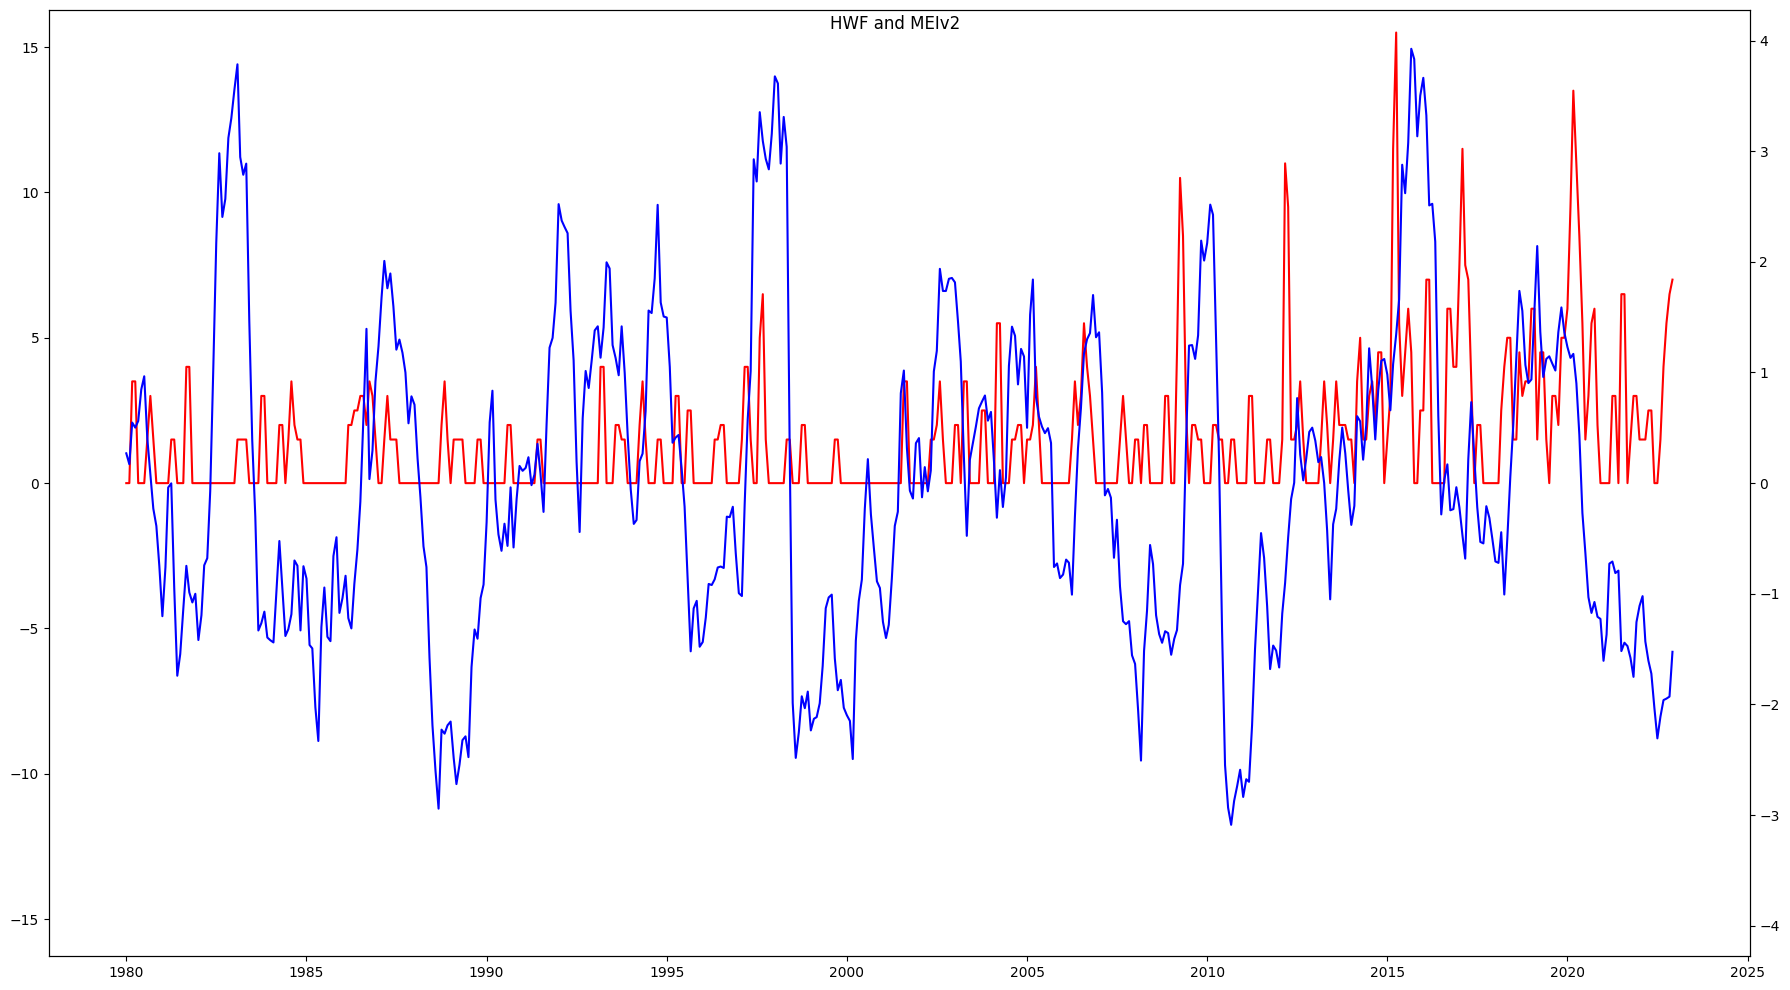

In [49]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(hwis.index, hwis["HWF"], color="red")
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

ax2 = ax.twinx()
ax2.plot(hwis.index, full_mei, color="blue")
yabs_max = abs(max(ax2.get_ylim(), key=abs))
ax2.set_ylim(ymin=-yabs_max, ymax=yabs_max)

fig.tight_layout() 
fig.suptitle("HWF and MEIv2")
plt.show()

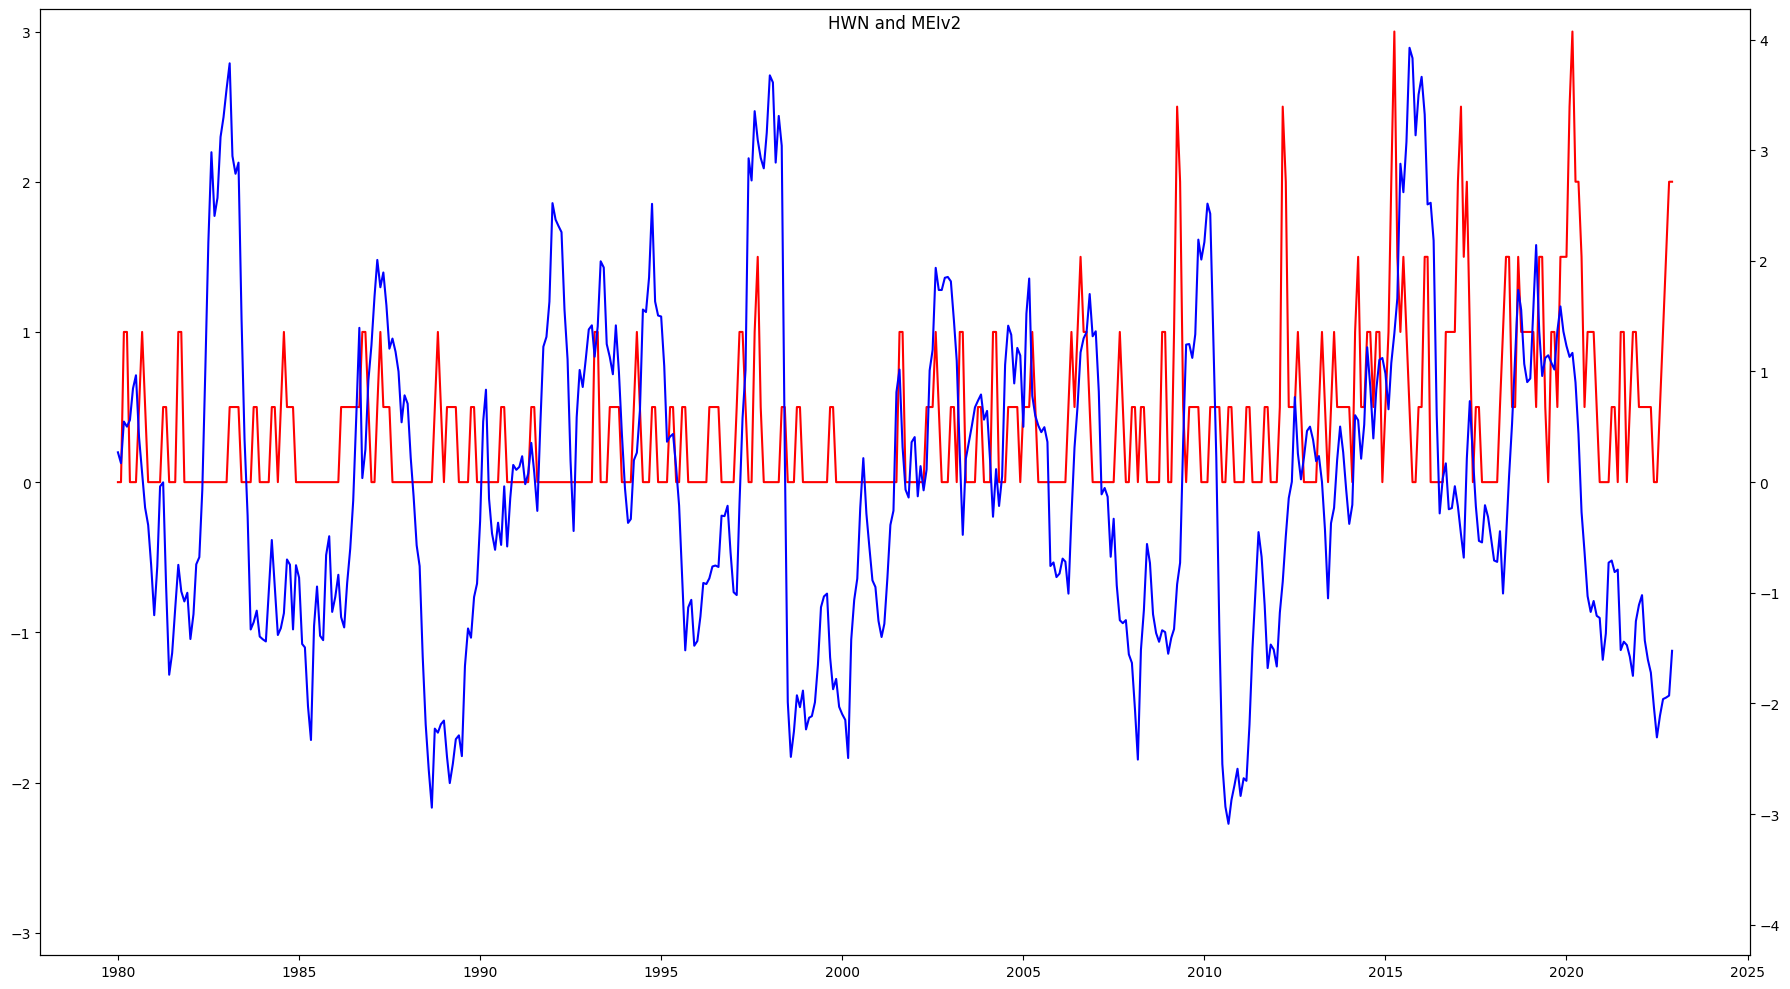

In [50]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(hwis.index, hwis["HWN"], color="red", label="HWN")
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

ax2 = ax.twinx()
ax2.plot(hwis.index, full_mei, color="blue", label="MEI.v2")
yabs_max = abs(max(ax2.get_ylim(), key=abs))
ax2.set_ylim(ymin=-yabs_max, ymax=yabs_max)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.suptitle("HWN and MEIv2")
plt.show()

## PC-2 on MEI box and HWN/HWF

In [53]:
full_mei = []
for i in range(len(pcs[0][1][1])):
    for k in range(12):
        full_mei.append(pcs[k][1][1][i])

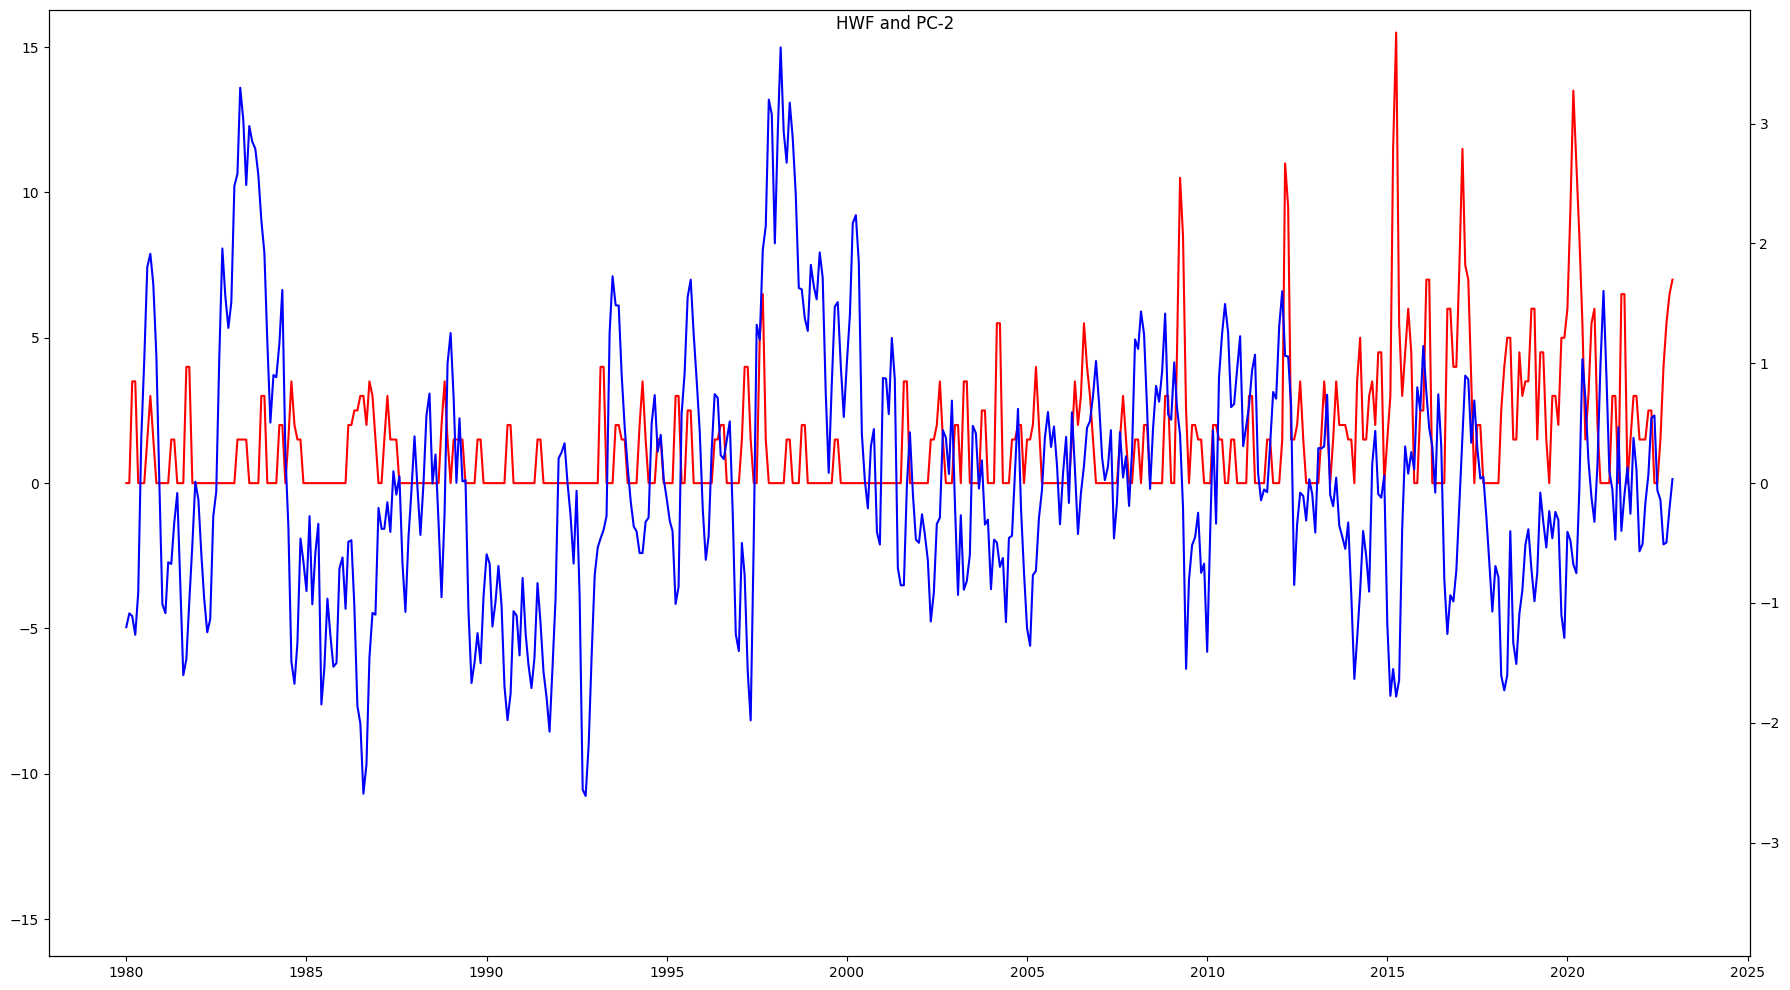

In [55]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(hwis.index, hwis["HWF"], color="red")
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

ax2 = ax.twinx()
ax2.plot(hwis.index, full_mei, color="blue")
yabs_max = abs(max(ax2.get_ylim(), key=abs))
ax2.set_ylim(ymin=-yabs_max, ymax=yabs_max)

fig.tight_layout() 
fig.suptitle("HWF and PC-2")
plt.show()

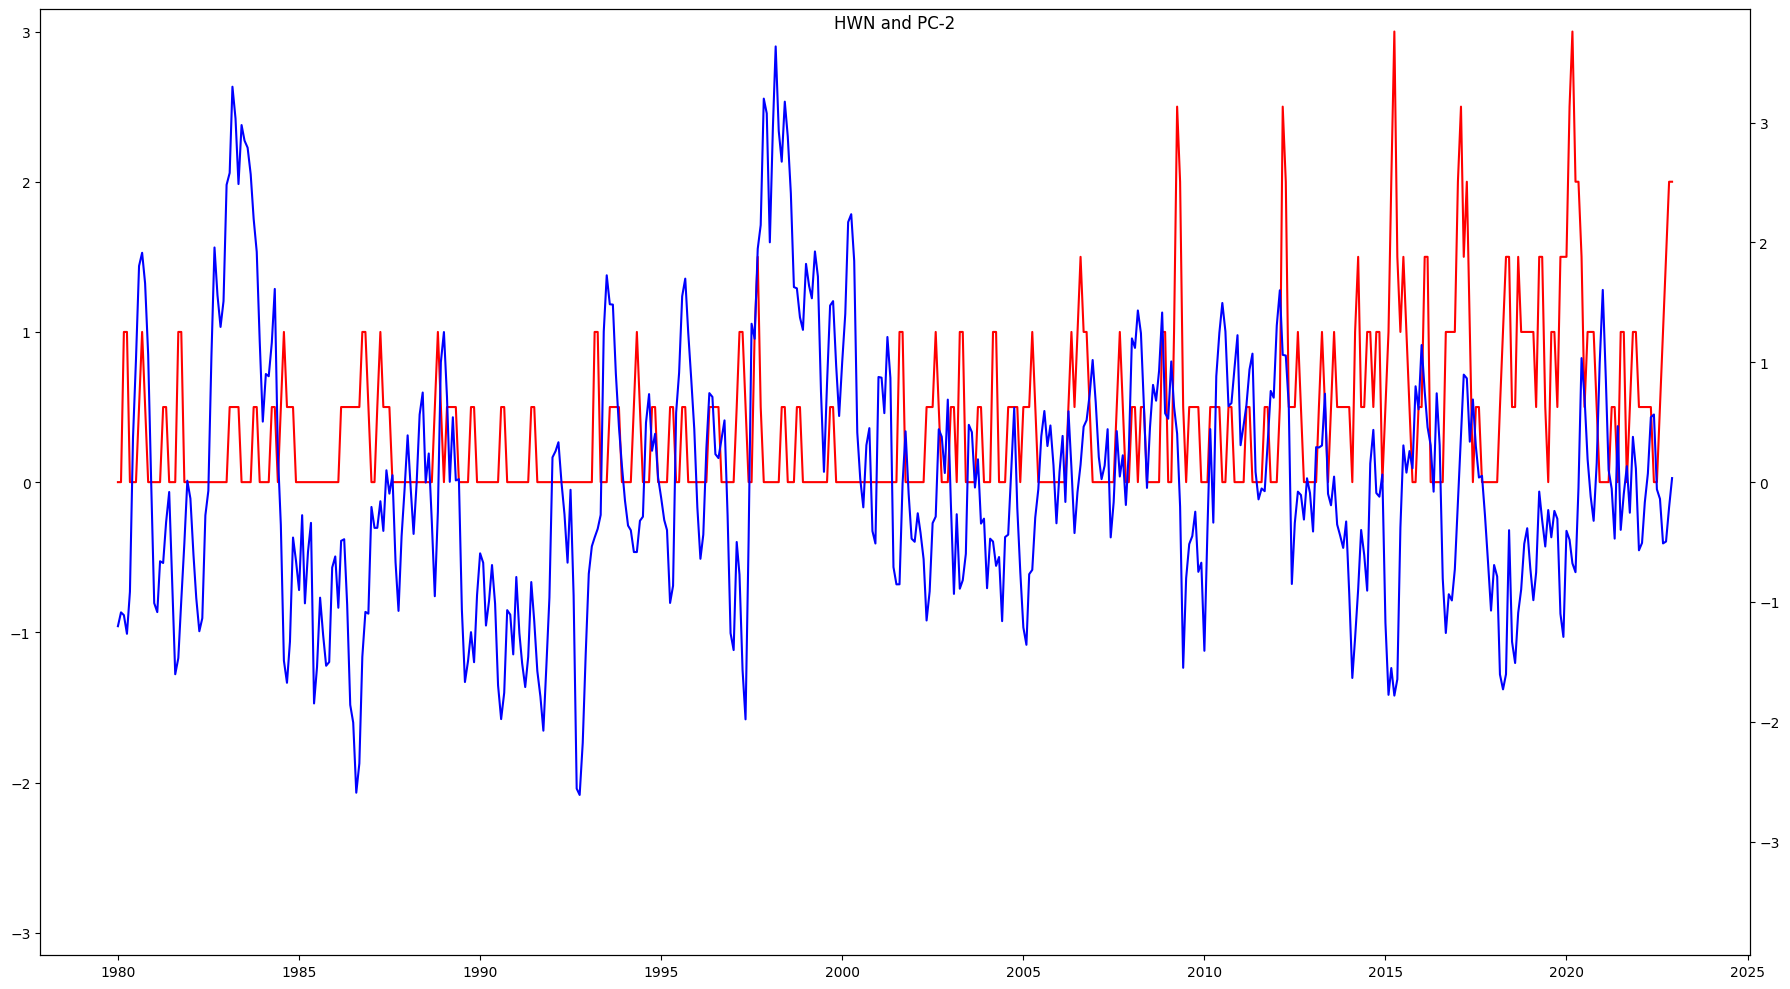

In [56]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(hwis.index, hwis["HWN"], color="red", label="HWN")
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

ax2 = ax.twinx()
ax2.plot(hwis.index, full_mei, color="blue", label="MEI.v2")
yabs_max = abs(max(ax2.get_ylim(), key=abs))
ax2.set_ylim(ymin=-yabs_max, ymax=yabs_max)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.suptitle("HWN and PC-2")
plt.show()